# Programming Exercise 3: Template

In [10]:
import numpy as np

import scipy.sparse as sp
import scipy.sparse.linalg as spla

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
import time

In [11]:
def criss_cross_mesh(n):
    ## Generates a criss-cross mesh of the unit square with n+1 nodes in each direction
    
    ## Returns: nodes:          an array with the coordinates of every node, i.e. nodes[k] = [x_k, y_k]
    ##          elements:       an array of the elements, each of them represented by the indices (in nodes) of its 3 vertices
    ##          boundary_nodes: a list of the indices (in nodes) of those nodes in the boundary of the domain
    
    x, y = np.meshgrid(np.linspace(0,1,n+1), np.linspace(0,1,n+1))
    # Reshape as 1D arrays
    x = x.ravel()[:, np.newaxis]
    y = y.ravel()[:, np.newaxis]
    
    nodes = np.hstack([x, y])
    
    elements = []
    for j in range(n):
        for i in range(n):
            # Add triangles from the box with lower-left corner (i/(n+1), j/(n+1))
            ###      d ------- c
            ###      |      /  |
            ###      |    /    |
            ###      |  /      |
            ###      a ------- b
            a = j*(n+1)+i
            b = a + 1
            c = b + n + 1
            d = a + n + 1
            
            elements.append([a, b, c]) # Lower-right triangle
            elements.append([a, c, d]) # Upper-left triangle
    
    elements = np.asarray(elements)
    
    boundary_nodes = []
    for k in range(n+1):
        boundary_nodes.append(k)         # Bottom side y = 0
        boundary_nodes.append(n*(n+1)+k) # Top side y = 1
    for k in range(1,n):
        boundary_nodes.append(k*(n+1))   # Left side x = 0
        boundary_nodes.append(k*(n+1)+n) # Right side x = 1
    
    return nodes, elements, boundary_nodes

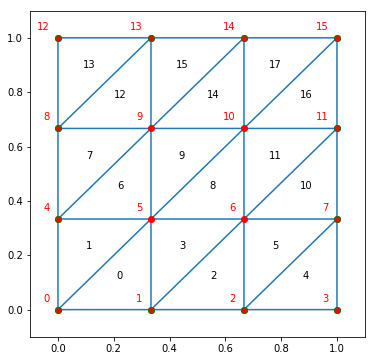

In [12]:
# Visualize the mesh for n = 3
nodes, elements, boundary_nodes = criss_cross_mesh(3)
fig = plt.figure(figsize=(6,6))

plt.triplot(nodes[:,0], nodes[:,1], elements) # Triangles
plt.plot(nodes[:,0], nodes[:,1], 'ro') # Nodes
plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], 'go', mfc='none') # Boundary nodes

for j, p in enumerate(nodes):
    plt.text(p[0]-0.03, p[1]+0.03, j, color='r', ha='right') # label points

for j, s in enumerate(elements):
    p = nodes[s].mean(axis=0)
    plt.text(p[0], p[1], '{}'.format(j), ha='center') # label triangles

plt.xlim(-0.1, 1.1); plt.ylim(-0.1, 1.1)
plt.show()

## (a)

In [13]:
def assemble_stiffness_matrix_local(vertex_coords):
    """
    assemples the local stiffness matrix
    vertex_coords = coordinates of the vertices as array [[x0, y0], [x1,y1], [x2,y2]]
    
    """
    a=vertex_coords[1]-vertex_coords[0]
    b=vertex_coords[2]-vertex_coords[0]
    det_B_T=np.absolute(a[0]*b[1]-a[1]*b[0])
    G_T=np.linalg.inv(np.array([[1,1,1],[vertex_coords[i,0] for i in [0,1,2]],[vertex_coords[i,1] for i in [0,1,2]]]))@np.array([[0,0],[1,0],[0,1]])
    
    return G_T@np.transpose(G_T)*0.5*det_B_T
    

def assemble_mass_matrix_local(vertex_coords):
    """
    
    """
    a=vertex_coords[1]-vertex_coords[0]
    b=vertex_coords[2]-vertex_coords[0]
    det_B_T=np.absolute(a[0]*b[1]-a[1]*b[0])
    
    return det_B_T*1./24*np.array([[2,1,1],[1,2,1],[1,1,2]])

In [14]:
def assemble_stiffness_matrix(elements, nodes):
    # Empty sparse matrix 
    A = sp.lil_matrix((len(nodes), len(nodes)))
    
    # Loop over all elements 
    for idx in elements:
        A[tuple(np.meshgrid(idx, idx))] += assemble_stiffness_matrix_local(nodes[idx])
    
    return sp.csr_matrix(A)

def assemble_mass_matrix(elements, nodes):
    M = sp.lil_matrix((len(nodes),len(nodes)))
    
    for idx in elements:
        M[tuple(np.meshgrid(idx,idx))] += assemble_mass_matrix_local(nodes[idx])
        
    return sp.csr_matrix(M)

#print(assemble_mass_matrix(elements,nodes))
#print(assemble_stiffness_matrix(elements,nodes))

## (b)

In [15]:
def solve(A, b, dirichlet_nodes):
    ## dirichlet_nodes LIST!!!!!!
    #first try ohne set
    #vllt wegen runtime nicht jedes MAl ein neues Objekt
    # ist nicht normales solve schneller, gucke ich später, die ERgebnisse scheinen aber zu stimmen

    n=len(b)
    all_indices={i for i in range(n)}
    dirichlet_nodes=set(dirichlet_nodes) #turns the list into a set
    non0_indices= all_indices -dirichlet_nodes
    start=time.time()
    indices= sorted(list(non0_indices))
    print("Runtime sorting: ", time.time()-start)
    
    A_schlange=sp.csr_matrix(np.array([[A[i,j] for j in indices]for i in indices]))
#    print(A_schlange)
#    print(A_schlange)
    b_schlange=np.array([b[i]for i in indices])
    
    start=time.time()
    restricted_res=spla.spsolve(A_schlange,b_schlange)
    print("Runtime restricted Problem: ", time.time()-start)
    res=[0 for i in range(n)]
    
    start=time.time()
    for i in list(indices):
        res[i]=restricted_res[0]
        restricted_res=restricted_res[1:]
    return np.array(res)
    print("Runtime assembly of result:", time.time()-start)

#V=np.reshape(np.array([i for i in range(16*16)]),(16,16))
#print(V)
#solve(V, np.array([i for i in range(16)]), [0,1,2,3,4,7,8,11,12,13,14,15])

runtime Matrix_assembly:  17.498037576675415
Runtime sorting:  0.0
Runtime restricted Problem:  0.601637601852417
Runtime solve:  2641.172792196274


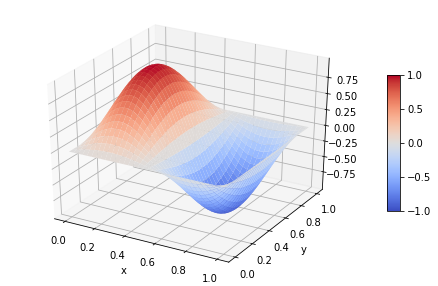

In [16]:

"""
STARK EXPeRIMENTELL:
# Test and plot on a 100x100 grid 
nodes, elements, boundary_nodes = criss_cross_mesh(100)

#f = lambda x: 5*np.pi**2*np.sin(2*np.pi*x[0])*np.sin(np.pi*x[1])
def f(x, y):
    return 5 * (np.pi**2) * np.sin(2 * np.pi * x) * np.sin(np.pi * y)

start=time.time()
A=assemble_stiffness_matrix(elements,nodes)
M=assemble_mass_matrix(elements,nodes)
print("runtime Matrix_assembly: ", -start+time.time())

x = (1. / 100) * np.linspace(0,100, 101)
X, Y = np.meshgrid(x, x)

#print(X)    
b = np.array(f(X.ravel(), Y.ravel()))
#print(M)
#print(b)
c = M.dot(b)

start=time.time()
u = solve(A,c,boundary_nodes)
print("Runtime solve: ", time.time()-start)
u=u.reshape(101,101)


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')

surf = ax.plot_surface(X, Y, u, cmap=plt.cm.coolwarm)
surf.set_clim(-1., 1.)
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()
"""

## (c)

Runtime sorting:  0.0
Runtime restricted Problem:  0.0


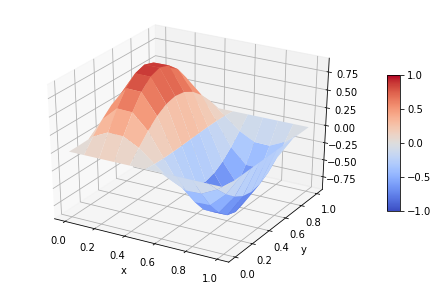

In [17]:
# Test and plot on a 10x10 grid 
nodes, elements, boundary_nodes = criss_cross_mesh(10)

#f = lambda x: 5*np.pi**2*np.sin(2*np.pi*x[0])*np.sin(np.pi*x[1])
def f(x, y):
    return 5 * (np.pi**2) * np.sin(2 * np.pi * x) * np.sin(np.pi * y)

A=assemble_stiffness_matrix(elements,nodes)
M=assemble_mass_matrix(elements,nodes)

x = (1. / 10) * np.linspace(0,10, 11)
X, Y = np.meshgrid(x, x)

#print(X)    
b = np.array(f(X.ravel(), Y.ravel()))
#print(M)
#print(b)
c = M.dot(b)

u = solve(A,c,boundary_nodes)
u=u.reshape(11,11)


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')

surf = ax.plot_surface(X, Y, u, cmap=plt.cm.coolwarm)
surf.set_clim(-1., 1.)
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

## (d)

In [ ]:
# Convergence of the (approximate) L^2 error

## Fill in